In [1]:
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import ares
from average_dTb import average_dTb
import os

In [2]:
def interp_dTb(param, z, mpi=True, adequate_random_v_streams=200):
    m_chi = param[0]
    
    directory = "average_dTb/m_chi"+"{:.2f}".format(m_chi)
    if os.path.exists(directory):
        if np.size(os.listdir(directory)) < adequate_random_v_streams:
            more_random_v_streams = adequate_random_v_streams - np.size(os.listdir(directory))
            print("{} more_random_v_streams will be generated for m_chi = {} GeV...".format(more_random_v_streams, m_chi))
        else:
            more_random_v_streams = 0
            z_array, dTb_averaged = np.load(directory+'_averaged.npy')
            print("Adequate random v_streams already exist for m_chi = {} GeV. Existing averaged dTb and z loaded.".format(m_chi))
            print("---"*15)
    else:
        more_random_v_streams = adequate_random_v_streams
        print("{} more random v_streams will be generated for m_chi = {} GeV...".format(more_random_v_streams, m_chi))
    
    if more_random_v_streams:
        z_array, dTb_averaged, m_chi = average_dTb(m_chi=m_chi, more_random_v_streams=more_random_v_streams, mpi=mpi, verbose=False)
    
    dTb = np.interp(z, z_array, dTb_averaged)
    return dTb

def residual(param, z_sample, dTb_sample, mpi=True):
    residual = interp_dTb(param, z_sample, mpi) - dTb_sample
    return residual

def fit_param(z_sample, dTb_sample, param_guess=[0.1], bounds=([0,10]), mpi=True):
    if z_sample.shape != dTb_sample.shape:
        print("z_sample and dTb_sample should have same shape.")
        return
    res = least_squares(residual, param_guess, diff_step=0.1, bounds=bounds, xtol=1e-3, args=(z_sample, dTb_sample, mpi))
    return res.x, res.success, res.status

In [3]:
def test(param_true=[0.15], mpi=True):
    # sampling
    z_sample = np.arange(10, 300, 5)
    dTb_accurate = interp_dTb(param_true, z_sample)
    noise = 3
    dTb_sample = dTb_accurate + noise * np.random.normal(size = z_sample.shape[0])
    
    # fitting
    param_fit, success, status = fit_param(z_sample, dTb_sample, mpi=mpi)
    print('---'*15)
    print('success =', success)
    print('status =', status)
    
    plt.figure(dpi=120)
    sim = ares.simulations.Global21cm(radiative_transfer=False, verbose=False)
    sim.run()
    plt.plot(sim.history['z'], sim.history['dTb'], label = 'no DM heating', color='k', linestyle='--')
    
    plt.plot(z_sample, dTb_accurate, label = r'$m_{\chi, \rm real}$'+' = {} GeV'.format(param_true[0]))
    plt.scatter(z_sample, dTb_sample, label=r'sample, $\sigma_{\rm noise}$'+' = {} mK'.format(noise), s=8)
    plt.plot(z_sample, interp_dTb(param_fit, z_sample), label = r'$m_{\chi, \rm fit}$'+' = {:.2f} GeV'.format(res.x[0]), linestyle=':', c='r')
    plt.xlim(0,300)
    # plt.ylim(-60,0)
    plt.xlabel(r"$z$")
    plt.ylabel(r"$\delta T_b \rm\ [mK]$")
    plt.legend()
    plt.title(r"infer $m_\chi$ via observing $\delta T_b$")
    plt.show()

5000


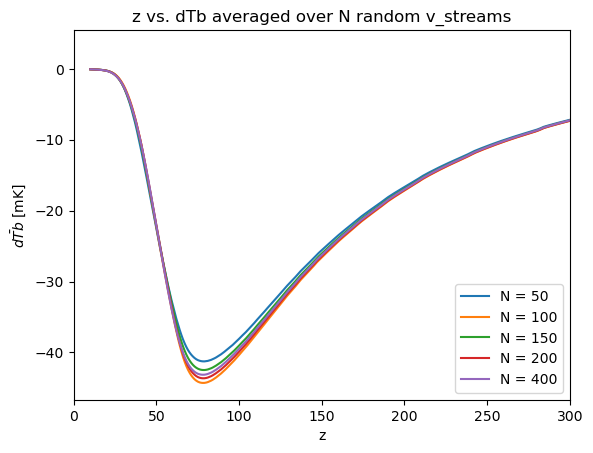

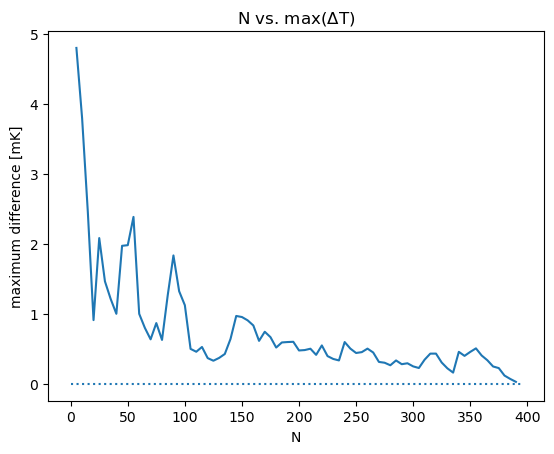

In [18]:
def demonstrate():
    z_array = np.linspace(10, 1010, 1000)

    try:
        file_names = os.listdir("average_dTb/m_chi0.62")
    except FileNotFoundError:
        print("Interrupt demonstrate() if you don't want following steps to cost long time.")
        average_dTb(m_chi=0.62, more_random_v_streams=400, mpi=1, verbose=False)
        file_names = os.listdir("average_dTb/m_chi0.62")
    
    for file_name in file_names:
        data = np.load("./average_dTb/m_chi0.62/{}".format(file_name))
        dTb_interp = np.interp(z_array, data[0][::-1], data[1][::-1])
        if "all_dTb_interp" not in vars():
            all_dTb_interp = dTb_interp.copy()
        else:
            all_dTb_interp = np.vstack((all_dTb_interp, dTb_interp))
    # print(all_dTb_interp.shape)

    N = [50, 100, 150, 200, 400]
    # plt.figure(dpi=150)
    dTb_averaged = [np.average(all_dTb_interp[:N[i]], axis=0) for i in range(len(N))]
    print(np.size(dTb_averaged))
    plt.title("z vs. dTb averaged over N random v_streams")
    for i in range(len(N)):
        plt.plot(z_array, dTb_averaged[i], label="N = {}".format(N[i]))
    plt.xlabel("z")
    plt.ylabel(r'$\bar{dTb}$ [mK]')
    plt.legend()
    plt.xlim(0,300)
    plt.show()

    N = np.arange(5, 400, 5)
    dTb_averaged = [np.average(all_dTb_interp[:N[i]], axis=0) for i in range(len(N))]
    # print(np.shape(dTb_averaged))
    dTb_averaged_diff = np.array([dTb_averaged[i] - dTb_averaged[-1] for i in range(len(N)-1)])
    # dTb_averaged_diff = dTb_averaged_diff[]
    # print(np.shape(dTb_averaged_diff))
    plt.plot(N[:-1], np.max(abs(dTb_averaged_diff), axis=1))
    plt.hlines(0, xmin=0, xmax=N[-1], linestyles=':')
    plt.xlabel("N")
    plt.ylabel("maximum difference [mK]")
    plt.title(r"N vs. max($\Delta$T)")

if __name__ == "__main__":
    demonstrate()

In [4]:
if __name__ == '__main__':
    test([0.2], mpi=False)

Adequate files already exist for m_chi = 0.2 GeV. Existing averaged dTb and z loaded.
---------------------------------------------
Adequate files already exist for m_chi = 0.1 GeV. Existing averaged dTb and z loaded.
---------------------------------------------
Adequate files already exist for m_chi = 0.11000000000000001 GeV. Existing averaged dTb and z loaded.
---------------------------------------------
119 more_random_v_streams will be generated for m_chi = 0.13180638976768505 GeV...
dark_matter_mass = 0.13180638976768505 GeV

/home/xia/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


KeyboardInterrupt: 